#  Overview

This notebook demonstrates how to discover raw RADARSAT-1 scenes from the EODMS Search service (STAC), evaluate their coverage over an area of interest, submit scenes to the EODMS Processing service (OGC Processes) for Level-1 processing, and download the resulting image products.


## Finding data using the EODMS Search API

In [1]:
%matplotlib inline

import os
from pathlib import Path
import requests
import json
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import contextily as ctx

from itertools import islice
from shapely.geometry import shape
from pystac_client import Client

We will search for RADARDSAT-1 scenes over Montreal between May 1st and August 31st, 2007

In [3]:
def get_bbox(geojson_path):
    """Extracts bounding box coordinates from an input vector data file"""
    gdf = gpd.read_file(geojson_path)
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    bbox = tuple([float(b) for b in gdf.total_bounds])

    return bbox

In [4]:
# date range for search
start_date = '2007-05-01'
end_date = '2007-08-31'

# creating bounding box from input GeoJSON to use as spatial filter
geojson_path = 'montreal-limites-administratives.geojson'
aoi_gdf = gpd.read_file(geojson_path)
bbox = get_bbox(geojson_path)
bbox

(-73.9966021388108, 45.3854030130529, -73.4738652778201, 45.7075796336657)

In [ ]:
# List all items in collection within date range that intersect with bounding box
catalog_url = 'https://www.eodms-sgdot.nrcan-rncan.gc.ca/search'
collection = 'Radarsat-1-FRED'

catalog = Client.open(catalog_url)
search = catalog.search(
    collections=[collection],
    bbox=bbox,
    datetime=f'{start_date}/{end_date}',
    limit=100,
    method='GET'
)

all_items = search.item_collection()
print(f'{len(all_items)} total products found')

# Filter for Single Beam Mode only (ScanSAR Mode is currently unsupported for L1 processing)
items = [item for item in all_items if item.properties.get('mode') == 'SB']
print(f'{len(items)} single-beam products after filtering')

13 total products found
7 single-beam products after filtering


Sorting the list of Radarsat-1-FRED products by percent coverage of GeoJSON AOI:

In [6]:
def calculate_coverage(item, aoi_gdf):
    "''Calculate the percent coverage of a STAC item footprint over a provided AOI geometry"""

    # default UTM zones
    utm_crs = aoi_gdf.estimate_utm_crs().to_epsg()
    aoi_gdf_utm = aoi_gdf.to_crs(utm_crs)

    # create GDF from STAC geometry and calculate intersection
    item_geom = shape(item.to_dict()['geometry'])
    item_gdf = gpd.GeoDataFrame([{'geometry': item_geom}], crs='EPSG:4326').to_crs(utm_crs)
    intersection = gpd.overlay(item_gdf, aoi_gdf_utm, how='intersection')
    
    # get AOI area 
    aoi_area = aoi_gdf_utm.geometry.area.sum()
    
    if len(intersection) > 0:
        intersection_area = intersection.geometry.area.sum()
        coverage_percent = float(round((intersection_area / aoi_area) * 100, 1))
    else:
        coverage_percent = 0.0
    
    return coverage_percent

In [7]:
def create_coverage_table(items, aoi_gdf):
    """Sorts all STAC items in an item_collection by percent coverage of an AOI"""
    
    dict_list = []
    for item in items:

        # percent coverage
        aoi_coverage = calculate_coverage(item, aoi_gdf)

        # item properties
        item_dict = item.to_dict()
        id = item_dict.get('id')
        datetime = item_dict.get('properties').get('datetime')
        beam_mnemonic = item_dict.get('properties').get('beam_mnemonic')
        orbit_direction = item_dict.get('properties').get('orbit_direction')

        dict_list.append({
            'id': id,
            'coverage': aoi_coverage,
            'datetime': datetime,
            'beam_mnemonic': beam_mnemonic,
            'orbit_direction': orbit_direction
        })

    # Return table with results
    coverage_table = pd.DataFrame(dict_list).sort_values(by='coverage', ascending=False)

    return coverage_table

In [8]:
coverage_table = create_coverage_table(items, aoi_gdf)
coverage_table

,id,coverage,datetime,beam_mnemonic,orbit_direction
0,56444f88-a0de-4f3f-9085-ef1f525563a1,100.0,2007-05-06T22:47:16.526000Z,F2,Ascending
1,c1741a68-249d-430e-a2b8-af0fc4f2a42c,100.0,2007-05-06T22:47:16.526000Z,F2,Ascending
3,836fbdc9-77fe-4988-8f52-c805fdf20cef,100.0,2007-05-30T22:47:12.200000Z,F2,Ascending
6,83865389-3adf-4265-83b8-c981a7f7e1a0,100.0,2007-08-25T10:48:54.742000Z,S7,Descending
2,a230254e-4edf-4c5f-b351-8890597d464f,43.0,2007-05-20T22:38:39.718000Z,S2,Ascending
5,2dc2cff1-781b-46c3-a070-9f1e5d94e052,8.0,2007-07-14T11:12:11.253000Z,S1,Descending
4,4451a1f9-27c2-4d6c-a484-3536d197937e,6.5,2007-06-07T10:53:27.514000Z,S7,Descending


We will take the highest-coverage Standard Beam product (`beam_mnemonic='S*'`) for further processing, and visualize its footprint on the map below:

In [9]:
standard_beam_products =  coverage_table[coverage_table['beam_mnemonic'].str.startswith('S')]
r1_product_id = standard_beam_products.iloc[0,0]
r1_item = [i for i in items if i.id == r1_product_id][0]
r1_product_id

'83865389-3adf-4265-83b8-c981a7f7e1a0'

In [10]:
def plot_item_footprint(item, aoi_gdf, figsize=(12, 8)):
    """Display a STAC item footprint over a basemap with a provided AOI geometry"""
    
    # Create geodataframe of item footprint
    item_geom = shape(item.to_dict()['geometry'])
    item_gdf = gpd.GeoDataFrame([{'geometry': item_geom}], crs=4326)

    # Reproject both GDFs to Web Mercator for basemap
    item_gdf_mercator = item_gdf.to_crs(3857)
    aoi_gdf_mercator = aoi_gdf.to_crs(3857)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot AOI
    aoi_gdf_mercator.boundary.plot(ax=ax, color='red', linewidth=2, label='AOI')
    aoi_gdf_mercator.plot(ax=ax, alpha=0.2, color='red', edgecolor='red')
    
    # Plot item footprint
    item_gdf_mercator.boundary.plot(ax=ax, color='blue', linewidth=2, label='Item Footprint')
    item_gdf_mercator.plot(ax=ax, alpha=0.1, color='blue', edgecolor='blue')
    
    # Add OSM basemap
    basemap=ctx.providers.OpenStreetMap.Mapnik
    ctx.add_basemap(ax, source=basemap, attribution_size=8)
    
    # Add title and legend
    item_id = item.to_dict()['id']
    datetime = item.to_dict()['properties'].get('datetime', 'N/A')
    
    ax.set_title(f'Product ID: {item_id}\n\nAcquisition Date: {datetime}', 
                 fontsize=12, pad=10)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    
    plt.tight_layout()
    
    return fig, ax

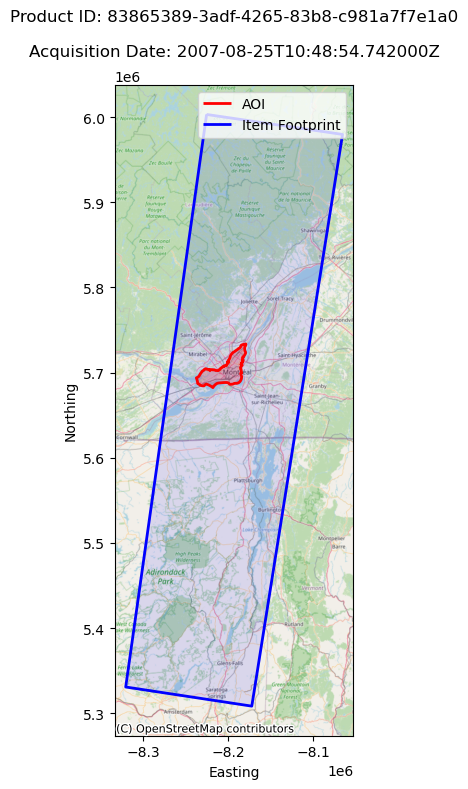

In [11]:
fig, ax = plot_item_footprint(r1_item, aoi_gdf)
plt.show()

Additional properties of the Radarsat-1 acquisition are as follows:

In [12]:
r1_item.to_dict().get('properties')

{'catalog_update_file': 'ACS__RS1616241GSP-RT-1366242727.22302__ACQ_MET',
 'mode': 'SB',
 'channel': 'REALTIME',
 'size_mb': 979,
 'datetime': '2007-08-25T10:48:54.742000Z',
 'dataset_id': 385657,
 'segment_id': '83865389-3adf-4265-83b8-c981a7f7e1a0',
 'total_frames': 2984406,
 'beam_mnemonic': 'S7',
 'stop_datetime': '2007-08-25T10:50:06.894+00:00',
 'downlink_orbit': 61624,
 'fred_data_file': 's3://radarsat-r1-raw-fred/gss/radarsat1/2021/61624/385657_01_20211121132517/RS0161624GSRT04P_20070825_104854_105008_S7_.10001',
 'frames_with_no_errors': 2984406,
 'orbit_direction': 'Descending',
 'submission_time': '2021-11-21T13:25:17+00:00',
 'archive_facility': 'GATN',
 'fred_volume_file': 's3://radarsat-r1-raw-fred/gss/radarsat1/2021/61624/385657_01_20211121132517/RS0161624GSRT04P_20070825_104854_105008_S7_.V10001',
 'acquisition_orbit': 61624,
 'reception_facility': 'GATN'}

## Submitting orders to the EODMS Processes API

All available processes can be listed through a GET request to the `/processing/processes` endpoint

In [ ]:
api_url = 'https://eodms-sgdot.nrcan-rncan.gc.ca/processing'
r = requests.get(f'{api_url}/processes')

if r.status_code == 200:
    all_processes = json.loads(r.content)
else:
    raise Exception(f'Request failed with status {r.status_code}: {r.text}')

# summarize results
for process in all_processes.get('processes'):
    if 'title' in process.keys():
        print(json.dumps(dict(islice(process.items(), 4)), indent=4))

{
    "title": "Radarsat-1 CEOS-L0 RAW",
    "description": "Generate a Radarsat-1 CEOS L0 RAW product",
    "keywords": [
        "Radarsat-1",
        "RAW",
        "CEOS",
        "L0"
    ],
    "id": "Radarsat1CEOSL0RAW"
}
{
    "title": "Radarsat-1 CEOS L1 SLC (16-bit)",
    "description": "Generate Radarsat-1 L1 product in CEOS SLC (16-bit)",
    "keywords": [
        "Radarsat-1",
        "SLC",
        "CEOS L1"
    ],
    "id": "Radarsat1CEOSL1SLC"
}
{
    "title": "Radarsat-1 GAMMA L1 SLC",
    "description": "Generate a Radarsat-1 L1 product in GAMMA SLC format",
    "keywords": [
        "Radarsat-1",
        "FRED",
        "SLC",
        "GAMMA",
        "L1"
    ],
    "id": "Radarsat1GAMMAL1SLC"
}


We can find the required input structure for a given process using the `processing/processes/{processID}` endpoint:

In [14]:
process_id = 'Radarsat1GAMMAL1SLC'
r = requests.get(f'{api_url}/processes/{process_id}')

if r.status_code == 200:
    gamma_process_description = json.loads(r.content)
    print(json.dumps(gamma_process_description.get('inputs'), indent=4))
else:
    raise Exception(f'Request failed with status {r.status_code}: {r.text}')

{
    "slc_type": {
        "title": "slc type",
        "default": "beta0",
        "minOccurs": 0,
        "description": "SLC Type: sigma0, gamma0, beta0",
        "enum": [
            "sigma0",
            "gamma0",
            "beta0"
        ],
        "maxOccurs": 1
    },
    "uuid": {
        "minOccurs": 1,
        "description": "The unique identifier of the L0 dataset",
        "type": "string",
        "title": "uuid",
        "maxOccurs": 1
    },
    "stop_time": {
        "minOccurs": 0,
        "type": "string",
        "title": "stop time",
        "description": "Stop time of FRED dataset extraction",
        "maxOccurs": 1
    },
    "lookup_table": {
        "maxOccurs": 1,
        "minOccurs": 0,
        "default": "mixed",
        "description": "lookup table to use for processing (16-bit mode only)",
        "title": "lookup table",
        "enum": [
            "ice",
            "mixed",
            "point-target",
            "constant-beta"
        ]
    },

An authorization token is required to send certain requests to the Processes API, created using your EODMS username and password. These values must be exported as environment variables `EODMS_USERNAME` and `EODMS_PASSWORD` before running the `get_auth_token()` function or executing any processes.

The following cell shows how to load these variables from a `.credentials` file with a structure of:

```bash
EODMS_USERNAME="foo"
EODMS_PASSWORD="bar"
```

In [15]:
credentials_path = '../.credentials'

if os.path.exists(credentials_path):
    with open(credentials_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                key, value = line.split('=', 1)
                value = value.strip('"').strip("'")
                os.environ[key] = value
    print('EODMS credentials loaded from .credentials file')
else:
    print('No .credentials file found. Please set EODMS_USERNAME and EODMS_PASSWORD manually.')

EODMS credentials loaded from .credentials file


In [ ]:
def get_auth_token():
    """
    Generates authorization token for EODMS Processes API.
    EODMS_USERNAME and EODMS_PASSWORD must be set as environment variables before running.
    """
    
    # get credentials from environment variables
    username = os.environ.get('EODMS_USERNAME')
    password = os.environ.get('EODMS_PASSWORD')

    if not username or not password:
        raise ValueError('EODMS_USERNAME and EODMS_PASSWORD environment variables must be set')
    
    auth_url = 'https://eodms-sgdot.nrcan-rncan.gc.ca/aaa/v1/login'
    
    headers = {
        'Accept': 'application/json',
        'Content-Type': 'application/json'
    }
    
    payload = {
        'grant_type': 'password',
        'username': username,
        'password': password
    }

    r = requests.post(auth_url, headers=headers, json=payload)
    
    if r.status_code == 200:
        token_data = r.json()
        return token_data
    
    else:
        raise Exception(f'Authentication failed with status {r.status_code}: {r.text}')

In [17]:
# Generate auth token
token_response = get_auth_token()
auth_token = token_response.get('access_token')
print(f'Authentication successful. Token expires in {token_response.get("expires_in")} seconds.')

Authentication successful. Token expires in 600 seconds.


Here is a function to submit a POST request to the `/processing/processes/{processID}/execution` endpoint given a product UUID and process ID with some other optional processing arguments:

In [18]:
def submit_r1_process(execution_url, r1_product_id, process_id, auth_token, slc_type='beta0', lookup_table='mixed', start_time=None, stop_time=None):
    """"""
    # build a JSON payload to POST to the endpoint
    payload = {
                'inputs': {
                    'uuid': r1_product_id,
                    'lookup_table': lookup_table,
                    'slc_type': slc_type,
                    'start_time': start_time,
                    'stop_time': stop_time
                },
                'outputs': {
                    f'{process_id}-response': {
                    'format': {
                        'mediaType': 'application/json'
                        }
                    }
                },
                'mode': 'async',
            }
    
    # drop any unused optional inputs
    if not start_time:
        payload.get('inputs').pop('start_time')
    if not stop_time:
        payload.get('inputs').pop('stop_time')

    # send POST request and return results
    headers = {
        'Authorization': f'Bearer {auth_token}',
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Prefer': 'respond-async'
    }
    
    r = requests.post(execution_url, headers=headers, json=payload)
    if r.status_code in [200, 201]:
        order_json = r.json()
        return order_json
    
    else:
        raise Exception(f'Request failed with status {r.status_code}: {r.text}')

Authorized via the token, we can submit a processing job for a given scene with the `Radarsat1GAMMAL1SLC` method and default `beta0` calibration:

In [19]:
execution_url = f'{api_url}/processes/{process_id}/execution'
r1_order = submit_r1_process(execution_url, r1_product_id, process_id, auth_token)

In [20]:
print(json.dumps(r1_order, indent=4))
r1_order_id = r1_order.get('jobID')

{
    "processID": "Radarsat1GAMMAL1SLC",
    "type": "process",
    "jobID": "01KBR157ZX5B5DGC531QBDRXA9",
    "status": "accepted",
    "created": "2025-12-05T19:52:23.808277Z",
    "started": "2025-12-05T19:52:23.808277Z"
}


## Monitoring job status

In [21]:
# first option: monitor job status using callback URLs in the /execution request payload

In [22]:
# second option: use custom polling function to /processing/jobs/{jobId}

## Accessing resulting L1 products

The `/processing/jobs/{jobId}/results` endpoint contains information on job results, including download links

We can loop through the results and download each file  locally with requests *(transition this to boto3 once URIs are finalized)*: